![Py4Eng](img/logo.png)

# Logistic Model
## Yoav Ram

In this session we will understand:
- how logistic models can be used to classify or predict categories
- how to fit logistic models to data using maximum likelihood and gradient descent, including deriving gradients using the chain rule
- how to visualize pair plots, logistic models, histograms, and ROC curves
- the very basics of sklearn and statsmodels

In [1]:
import urllib.request
import os
import zipfile

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import logit, expit
import seaborn as sns

import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)

blue, green, red = sns.color_palette('muted', 3)
sns.set(
    style='ticks',
    context='talk',
    palette='Set1'
)

/Users/yoavram/miniconda3/envs/DataSciPy/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In the previous section we used one feature with integer values to predict another integer value.
What if we want to predict a category or class (i.e. classify or categorize) instead of predicting a number?

There are many ways to classify data (even without a training set), and one of the most common is **logistic regression**. 
But *regression* is usually used for predicting real numbers, how is regression related to classification?
In logistic regression we are trying to regress (predict a real number) the probability of some data being in a one class and not the other. 
Logistic regression is binomial (two classes, one free variable) but it can easily be expanded to *multinomial logistic regression*, sometimes also known as *softmax regression*.

# Get me the data

Let's start with a concrete example.
We'll get some data related to the Titanic (courtesy of the [IPython Cookbook](http://ipython-books.github.io/) by Cyrille Rossant, originally from the [kaggle Titanic challenge](https://www.kaggle.com/c/titanic).

![Titanic](https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/RMS_Titanic_3.jpg/600px-RMS_Titanic_3.jpg)

In [2]:
filename = '../data/titanic.zip'
titanic_zip = zipfile.ZipFile(filename)
with titanic_zip.open('data/titanic_train.csv') as f:
    df = pd.read_csv(f)

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


OK, let's just work with three features (not just one) - `Sex`, `Age` and `Pclass`.
We will treat `Sex` as a category (0 or 1), `Age` as a number (positive intger), `Pclass` as another number, because it is the ticket class.

We will try to predict the `Survived` variable, which is simply 0 or 1.

In [3]:
feature_names = ['Sex', 'Age', 'Pclass', 'Survived']
df = df[feature_names].copy() # what if I don't put .copy?
df['Sex'] = df['Sex'] == 'female' # convert to boolean
df['Sex'] = df['Sex'].astype(int) # then convert to int
df = df.dropna() # remove rows with "not a number" elements
df.head()

,Sex,Age,Pclass,Survived
0,0,22.0,3,0
1,1,38.0,1,1
2,1,26.0,3,1
3,1,35.0,1,1
4,0,35.0,3,0


# Data exploration

First, lets explore the data. 
Seaborn's `pairplot` doesn't work very well here, because three of the four variables (Sex, Pclass, and Survived) are categorical (actually Pclass is discrete but ordered).
So we will create our own version that has the histograms on the top row and a categorical plot (in this case, a violin plot, rather than a boxplot; it shows the estimated distribution of the data).

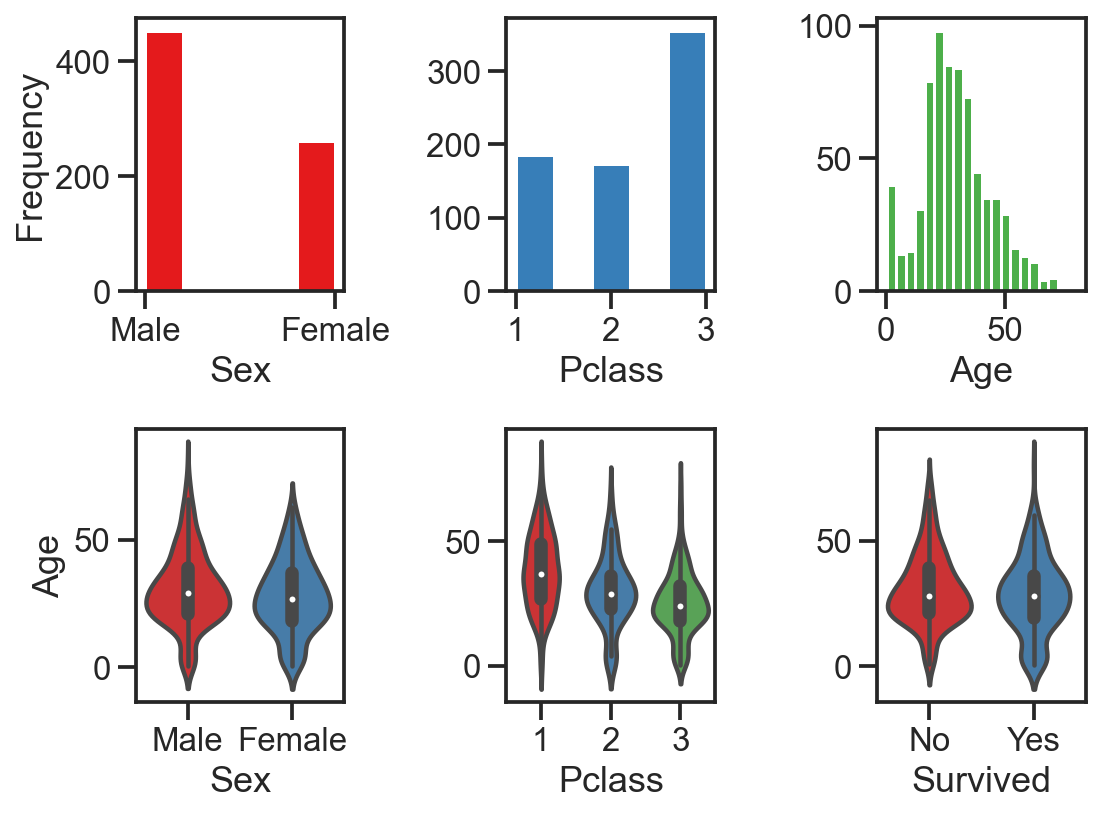

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(8, 6))

for var, c, ax in zip(['Sex', 'Pclass', 'Age'], sns.color_palette(), axes[0]):
    sns.distplot(df[var], color=c, kde=False, ax=ax, hist_kws=dict(alpha=1))
    ax.set_xlabel(var)
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_xticklabels(['', 'Male', 'Female'])

sns.violinplot(x="Sex", y="Age", data=df, ax=axes[1,0])
axes[1,0].set_xticklabels(['Male', 'Female'])

sns.violinplot(x="Pclass", y="Age", data=df, ax=axes[1,1])

sns.violinplot(x="Survived", y="Age", data=df, ax=axes[1,2])
axes[1,2].set_xticklabels(['No', 'Yes'])

for ax in axes[1, 1:]:
    ax.set_ylabel('')
fig.tight_layout()

It seems that there is a negative correlation between Pclass and Age (young people are more likely to be in low class). So we should remember that when interpreting results.

# Logistic regression

Let's try and use logistic regression to clear this up (if we can).
How does it work?

We briefly mentioned that when predicting integer values, the normal distribution, and hence the *normal linear model*, is not be the best model, and demonstrated that a [GLM](https://en.wikipedia.org/wiki/Generalized_linear_model) with a Poisson distribution and a log link function intead of a normal distribution performed better.

We will do a similar trick here.

We first use a linear model (as we did before) to predict the **log-odds** for survival.

Odds here is actually short for odds-ratio (OR), which is just the ratio of the probability that something happens and the probability that it does not happen:
$$
OR = 
\frac{P(\text{Survived})}{P(\text{Died})}
$$
so when the odds-ratio is 1, both events are as likley, and when it is >1 (<1) survival (death) is more likely.

We use the odds-ratio instead of the probability itself, because it is a value between 0 and $\infty$, rather then between 0 and 1, which is important both for mathematical formality, as the linear model is unbounded, and for interpretation - the odds can be doubles again and again (2:1 becoming 4:1 becomnig 8:1...) whereas the probability cannot (what is the double of 75%?).

The log-odds, which we mark as $z$, is the natural logarithm of the odds ratio.
$$
z = 
\log{\frac{P(\text{Survived})}{P(\text{Died})}} = 
\log{\frac{P(y=1)}{P(y=0)}}
$$
Why use the log-odds? Because (i) it is more mathematically convinient, as log-odds is symmetric in $P(..)$, whereas odds is not, and (ii) it is easier to interpret, as we will see below.

So when the log-odds-ratio is 0, both events are as likley, and when it is positive (negative) survival (death) is more likely.

So to use a linear model for predicting the log-odds, we have $m$ features, $x_1, x_2, \ldots, x_m$, and we try to estimate coefficients $a_0, a_1, \ldots, a_m$ such that
$$
z = a_0 + a_1 x_1 + \ldots + a_m x_m
$$
gives us a good estimation of the real log-odds.

But we want to estimate $\widehat{y}=P(y=1)$. Another nice feature of the log-odds is that it is invertible: from the log-odds we can find the probability for the event to occur using the *logisitic* (hence the name of the method!) which is also called the *expit* function:
$$
\widehat{y} = P(y=1) = expit(z) = \frac{1}{1+e^{-z}}
$$

In [5]:
features = ['Sex', 'Age', 'Pclass']
X = df[features]
Y = df['Survived']

In [6]:
def logodds(X, a):
    Z = X @ a
    return Z

In [7]:
a = np.array([1, 2, 3])
print(logodds(X, a)[:5])

0    53.0
1    80.0
2    62.0
3    74.0
4    79.0
dtype: float64


# Maximum likelihood

Now we want to find suitable $a_i$ such that we make a good prediction. 
We'll use *maximum likelihood* again.

Given data $(x, y)$ where $x=(x_1, x_2, x_3)$ are some numbers and $y$ is either 0 or 1, the logistic model provides us an estimate $\widehat y$ for the probability that $y=1$:

$$
\widehat{y} = P(\text{Survived})= P(y=1)=\frac{1}{1+e^{-z}} = 
\frac{1}{1+e^{-a_1 x_1 - a_2 x_2 -a_3 x_3}}
$$

The distribution of $y$ here is very straightforward - the Bernoulli distribution with success probability $\widehat{y}$, which equals to Binomial distribution with number of trials $n=1$ and success probability $\widehat{y}$:

$$
y \sim Bin(1, \widehat{y})
$$

The likelihood of this model is

$$
\mathbf{L}(a_1, a_2, a_3 \mid x_1, x_2, x_3, y) = 
P(y \mid a_1, a_2, a_3, x_1, x_2, x_3) = 
\cases{
    \widehat{y}, & y=1 \\
    1-\widehat{y}, & y=0
}
$$

If we have many $(x,y)$ pairs, and we will **assume that each pair is independent** (which maybe we can't always do, and specifically in the Titanic case we probably shouldn't do, but ok) then the joint likelihood of all the pairs is just the product of all the pair likelihoods: the product is used because the joint probability of independent events occuring is the product of their occurence probabilities.
Writing the set of $x$s as $X$ and the corresponding set of $y$s as $Y$, and because $y$ are either 0 or 1,

$$
\mathbf{L}(a_1, a_2, a_3 \mid X, Y) = 
\prod_{i=1}^{n} {(\widehat{y}_i)^{y_i} \; (1-\widehat{y}_i) ^{1-y_i}}
$$

We'll use the log-likelihood because otherwise we will have to deal with a product of really small numbers; so we take the sum of the log of the likelihood $\mathbf{L}$ of the the $(x, y)$ pairs (sum because the log of products is the sum of logs). The use of log here is not "magic", it's a mathematical convenience. It just happens that "log-likelihood" sounds very impressive.

$$
\log{\mathbf{L}(a_1, a_2, a_3 \mid X, Y)} = 
\sum_{i=1}^{n} {y_i \log{\widehat{y}_i} + (1-y_i) \log{(1-\widehat{y}_i)}}
$$

This is very similar to the negative of an information theory function called [*cross entropy*](https://en.wikipedia.org/wiki/Cross_entropy), and we usually average it over all the samples so that we can compare cross entropies between datasets of different size:

$$
\mathbf{J}(a_1, a_2, a_3, X, Y) = -\frac{1}{n} \log{\mathbf{L}(a_1, a_2, a_3 \mid X, Y)}
$$

where $n$ is the number of samples in $X,Y$.

### Numerical stability

Due to numerical issues when using very small or very large numbers, we should play around with the definition a little bit to find an expression that we can calculate with good numerical stability.

Note that
$$
\log{\widehat{y}} = -\log{\Big(1 + e^{-z}\Big)}  = -\log{\Big(1 + e^{-z}\Big)} \\
\log{(1-\widehat{y})} = -z - \log{\Big(1 + e^{-z}\Big)}
$$
and therefore
$$
y \log{\widehat{y}} + (1-y) \log{(1-\widehat{y})} = \\
-y \log{\Big(1 + e^{-z}\Big)} + (1-y)\Big(-z - \log{\Big(1 + e^{-z}\Big)}\Big) = \\
(1-y)z - \log{\Big(1 + e^{-z}\Big)}
$$

Finally,
$$
\log{\mathbf{L}(a_1, a_2, a_3 \mid X, Y)} = 
\sum_{i=1}^{n} {-z_i (1-y_i) - \log{\Big(1 + e^{-z_i}\Big)}},
$$
where $z_i = a_1 x_{i,1} + a_2 x_{i,2} + a_n x_{i,3}$ and $i$ is the sample index.

# Exercise: cross-entropy

Implement the cross entropy function.

**Reminder**
- Edit cell by double clicking
- Run cell by pressing _Shift+Enter_
- Get autocompletion by pressing _Tab_
- Get documentation by pressing _Shift+Tab_
- solution is [available](../solutions/logistic-model.py)

In [9]:
def cross_entropy(X, Y, a):
    pass

In [10]:
cross_entropy(X, Y, a)

40.89217186890601

# Gradient descent and the chain rule

Now we can minimize the cross entropy using gradient descent.
We need to calculate the derivative of the cross entropy with regards to $a_i$.
We will use the [chain rule](https://en.wikipedia.org/wiki/Chain_rule): 

$$
f(g(x))' = f'(g(x)) \cdot g'(x), 
$$

which is easier to write as 

$$
\frac{dx}{dy} = \frac{dx}{dz} \cdot \frac{dz}{dy}
$$

because then we can eliminate fractions as if these were fractions and not [infinitesimals](https://en.wikipedia.org/wiki/Infinitesimal).

Remember that $z=\text{log-odds} = a_1 x_1 + a_2 x_2 + a_3 x_3$ and $\mathbf{J}$ is the cross entropy function which we want to minimize.

Then for a single sample $(x, y)$:
$$
\frac{\partial \mathbf{J}}{\partial a_k} = 
\frac{\partial \mathbf{J}}{\partial \widehat y} \cdot \frac{\partial \widehat y}{\partial z} \cdot \frac{\partial z}{\partial a_k}
$$

The easiest one is:

$$
\frac{\partial z}{\partial a_k} = x_k
$$

The derivative of the logistic function is (you can verify later):

$$
\frac{\partial \widehat y}{\partial z} = \widehat y ( 1-\widehat y )
$$

Next, because $\frac{d}{dx} log(x) = \frac{1}{x}$ (again, you can verify this),

$$
\frac{\partial \mathbf{J}}{\partial \widehat y} = 
- \frac{\partial}{\partial \widehat y} \big(y \log{\widehat{y}} + (1-y) \log{(1-\widehat{y})}\big) = \\
-y \cdot \frac{1}{\widehat y} + (1-y) \cdot \frac{1}{1-\widehat y} = \\
\frac{\widehat y - y}{\widehat y ( 1 - \widehat y)}
$$

Putting it all together,
$$
\frac{\partial \mathbf{J}}{\partial a_k} = 
\frac{\partial \mathbf{J}}{\partial \widehat y} \cdot \frac{\partial \widehat y}{\partial z} \cdot \frac{\partial z}{\partial a_k} = \\
\frac{\widehat y - y}{\widehat y ( 1 - \widehat y)} \cdot \widehat y ( 1-\widehat y ) \cdot x_k = \\
(\widehat y - y) \cdot x_k
$$

which you have to admit is pretty cool: this is the residual (i.e. difference between the predicted and oberverd probabilities, $\widehat y - y$), so 0 when you got it right and 1 or -1 when you got it completely wrong, multiplied by the stength of the signal, so that strong signals (large $x_k$) have a stonger gradient and stonger effect on the result.

This was the gradient for a single sample. We average it over all samples to get a good estimate of the "real gradient" (law of large numbers etc.).

# Exercise: gradient descent

Implement a `gradient_descent(X, Y, a, η)` function, similar to the one we had in the [linear model session](linear-model.ipynb), which returns updated values for the coefficients based on one iteration of the gradient descent algorithm.
Use the above derivation to calculate the gradients and return updated coefficients.

In [11]:
def gradient_descent(X, Y, a, η=0.01):
    ### your code here

In [12]:
print(gradient_descent(X, Y, a))

Sex       0.999104
Age       1.818130
Pclass    2.985238
dtype: float64


# Fitting the logistic model

Fitting the model is done in much the same way as we did with the linear model - just have to choose initial coefficeints, different stopping condition, and adjust to the API of the new `gradient_descent` function.

This time we stop when the difference in cross entropy between two iterations is smaller than some value ($10^{-4}$).

In [13]:
def logistic_model(X, Y, a=(1, 1, 1), iters=10000, history=None):
    a = np.array(a)
    for t in range(iters+1):
        a = gradient_descent(X, Y, a)
        if t % 1000 == 0:
            print("{}: loss={:.6f}, a={}".format(t, cross_entropy(X, Y, a), a.values))
        if history is not None: history.append([a, cross_entropy(X, Y, a)])
    return a

In [14]:
history = []
a = logistic_model(X, Y, history=history)

0: loss=16.424619, a=[0.99910465 0.81814023 0.98525564]
1000: loss=0.566328, a=[ 1.62415016  0.02186743 -0.4703587 ]
2000: loss=0.484899, a=[ 2.02138068e+00 -5.75467263e-04 -5.46054452e-01]
3000: loss=0.479987, a=[ 2.22706976 -0.00313779 -0.57979328]
4000: loss=0.478104, a=[ 2.36138952 -0.00329144 -0.60278092]
5000: loss=0.477268, a=[ 2.45084731 -0.00336839 -0.61851448]
6000: loss=0.476887, a=[ 2.51120755 -0.00340857 -0.62932407]
7000: loss=0.476711, a=[ 2.55229332 -0.00343041 -0.63677211]
8000: loss=0.476628, a=[ 2.58042642 -0.00344277 -0.64191456]
9000: loss=0.476589, a=[ 2.59976883 -0.00345002 -0.64547029]
10000: loss=0.476570, a=[ 2.61310454 -0.00345444 -0.6479314 ]


In [15]:
print("Odds-ratios:")
print(np.exp(a))

Odds-ratios:
Sex       13.641335
Age        0.996552
Pclass     0.523127
dtype: float64


We can interpret these results as follows:
- women were much more likely to survive
- older passengers were less likely to survive
- passengers with expensive tickets were much move likely to survive

but remember the correlation we found between Age and Pclass...

# Off-the-shelf solutions

Of course, we should use solutions that someone else already optimized and debugged.

## Scikit-learn

[scikit-learn](http://scikit-learn.org/stable/index.html) is an awesone machine learning package will very good documentation.
Note that the package name is `sklearn`.

In [20]:
from sklearn.linear_model import LogisticRegression

In [21]:
model = LogisticRegression(fit_intercept=False)
model.fit(X, Y)
model.score(X, Y)

0.7801120448179272

We can plot the [ROC curve](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_roc_curve_visualization_api.html). 

Note: If the import fails, you can upgrade (later) Scikit-learn to version >= 0.22. 

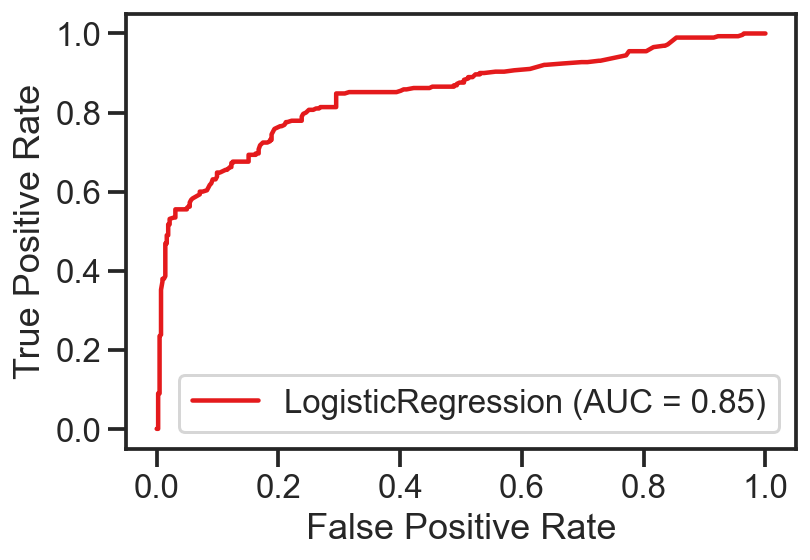

In [22]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(model, X, Y);

## Statsmodels

[Statsmodels](http://statsmodels.sourceforge.net/) is also a good package, more oriented to statistics then machine learning.

Note that statsmodels uses IRLS to find the maximum likelihood, rather than gradient descent, and therefore it is much faster.

In [23]:
import statsmodels.api as sm

In [24]:
logit = sm.Logit(Y, X)
result = logit.fit()
predictions = result.predict(X) > 0.5
truth = df['Survived'].values
print("Accuracy: {}".format((predictions == truth).mean()))

Optimization terminated successfully.
         Current function value: 0.476553
         Iterations 6
Accuracy: 0.7801120448179272


In [25]:
summary = pd.concat([
    np.exp(result.params),
    np.exp(result.conf_int()),
    result.pvalues
], axis=1)
summary.columns = ['Odds ratio', '95% CI Low', '95% CI High', 'P-value']
summary

,Odds ratio,95% CI Low,95% CI High,P-value
Sex,14.056245,9.633298,20.509905,8.809118e-43
Age,0.996543,0.987879,1.005283,4.370385e-01
Pclass,0.520227,0.451981,0.598779,8.395339e-20


# References

- Pawitan Y, 2001. *In all likelihood: statistical modelling and inference using likelihood*. **Ch. 6.2**.
- Cyrille Rossant, 2014. [IPython Interactive Computing and Visualization Cookbook](https://ipython-books.github.io/cookbook/) (a similar Titanic example is shown in chapter "Predicting who will survive on the Titanic with logistic regression"). 
- Scikit-learn documentation has a [tutorial](http://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html#classification) using the classical Iris dataset, with examples for other classification methods other than logistic regression.

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com).

The notebook was written using [Python](http://python.org/) 3.7.

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)